# Salary Analysis for Job Postings

This notebook analyzes job posting data to understand factors affecting salary levels and build predictive models.

## 1. Setup and Data Import

Import necessary libraries upfront

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime

Machine learning libraries

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from joblib import dump, load

Visualization libraries

In [3]:
import plotly.express as px
import plotly.graph_objects as go
#from dash import Dash, dcc, html, Input, Output

Set working directory

In [4]:
os.chdir('/Users/zouzhaoling/Desktop/243/Project')

## 2. Data Loading and Initial Inspection

Load the dataset

In [5]:
Job_Postings_with_Salary = pd.read_csv("Job_Postings_with_Salary_Data.csv")

/var/folders/k5/9zd_k44s42l7lr06cxvvrs080000gn/T/ipykernel_10361/1289687664.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  Job_Postings_with_Salary = pd.read_csv("Job_Postings_with_Salary_Data.csv")


Display basic information about the dataset

In [6]:
Job_Postings_with_Salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3258091 entries, 0 to 3258090
Data columns (total 27 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0        int64  
 1   JOB_ID            int64  
 2   VERTICAL          float64
 3   COMPANY           object 
 4   POST_DATE         object 
 5   SALARY            float64
 6   LOCATION          object 
 7   CITY              object 
 8   STATE             object 
 9   STATE_LONG        object 
 10  ZIP               float64
 11  COUNTY            object 
 12  REGION_STATE      object 
 13  LATITUDE          float64
 14  LONGITUDE         float64
 15  COMPANY_REF       object 
 16  COMPANY_PARENT    object 
 17  SIC_PRIMARY       object 
 18  NAICS_PRIMARY     object 
 19  TICKER            object 
 20  SCRAPE_TIMESTAMP  object 
 21  MODIFY_TIMESTAMP  object 
 22  META_NUM_ROLES    float64
 23  META_NUM_TAGS     float64
 24  META_NUM_TITLES   float64
 25  SALARY_MODELED    float64
 26  ROLE_PRIMARY  

Preview the first few rows

In [7]:
Job_Postings_with_Salary.head(5)

,Unnamed: 0,JOB_ID,VERTICAL,COMPANY,POST_DATE,SALARY,LOCATION,CITY,STATE,STATE_LONG,...,SIC_PRIMARY,NAICS_PRIMARY,TICKER,SCRAPE_TIMESTAMP,MODIFY_TIMESTAMP,META_NUM_ROLES,META_NUM_TAGS,META_NUM_TITLES,SALARY_MODELED,ROLE_PRIMARY
0,7012197,823218878177393,NaN,VisionQuest National LTD,2023-04-12,NaN,Easton| MD 21601,Easton,MD,Maryland,...,NaN,NaN,NaN,2023-04-12 11:00:07.000,2024-03-12 15:30:03.000,82.0,227.0,1.0,NaN,NaN
1,4987586,823218852001706,NaN,Saint Mary's Regional Health System,2023-01-11,50300.0,Russellville| AR 72802| |72802,NaN,NaN,NaN,...,NaN,NaN,NaN,2023-01-11 03:15:02.000,2023-05-06 20:19:08.000,5.0,22.0,1.0,NaN,NaN
2,6019751,823218908925629,NaN,UHC United Hospital Center,2023-08-29,35500.0,Bridgeport| WV 26330,Bridgeport,WV,West Virginia,...,NaN,NaN,NaN,2023-08-29 14:51:09.000,2023-10-18 14:25:09.000,2.0,7.0,1.0,NaN,NaN
3,8587093,823218888098324,NaN,Wayne State University,2023-05-17,38334.0,Detroit| MI,Detroit,MI,Michigan,...,82210102,NaN,NaN,2023-05-17 20:22:59.000,2023-10-18 14:17:43.000,8.0,36.0,1.0,NaN,NaN
4,6148057,823218873714064,NaN,Talent4health,2023-03-25,85500.0,Edison| NJ 08818,Edison,NJ,New Jersey,...,NaN,NaN,NaN,2023-03-28 03:15:03.000,2023-10-18 14:17:43.000,4.0,6.0,1.0,NaN,NaN


## 3. Data Cleaning and Preprocessing

### 3.1 Convert Date Columns & Remove Duplicates

Convert date columns to datetime format

In [8]:
Job_Postings_with_Salary['POST_DATE'] = pd.to_datetime(Job_Postings_with_Salary['POST_DATE'], errors='coerce')
Job_Postings_with_Salary['SCRAPE_TIMESTAMP'] = pd.to_datetime(Job_Postings_with_Salary['SCRAPE_TIMESTAMP'], errors='coerce')

Remove duplicate job postings

In [9]:
Job_Postings_with_Salary = Job_Postings_with_Salary.drop_duplicates()

Check dataset shape after duplicate removal

In [10]:
print("Dataset shape after duplicate removal:", Job_Postings_with_Salary.shape)

Dataset shape after duplicate removal: (3258091, 27)


Check date ranges

In [11]:
date_columns = ['POST_DATE', 'SCRAPE_TIMESTAMP']
for col in date_columns:
    min_date = Job_Postings_with_Salary[col].min()
    max_date = Job_Postings_with_Salary[col].max()
    print(f"{col}: From {min_date} to {max_date}")

POST_DATE: From 2023-01-01 00:00:00 to 2024-01-21 00:00:00
SCRAPE_TIMESTAMP: From 2023-01-01 02:44:02 to 2024-10-29 06:08:58


### 3.2 Handling Missing Values

Check for missing values

In [12]:
missing_values = Job_Postings_with_Salary.isnull().sum()
print("Missing Values Count:\n", missing_values)

Missing Values Count:
 Unnamed: 0                0
JOB_ID                    0
VERTICAL            3258091
COMPANY               77648
POST_DATE                 0
SALARY               842655
LOCATION              77469
CITY                 674135
STATE                674135
STATE_LONG           674940
ZIP                  699031
COUNTY               739271
REGION_STATE         722830
LATITUDE             734425
LONGITUDE            734425
COMPANY_REF         1174270
COMPANY_PARENT      1877787
SIC_PRIMARY         1817236
NAICS_PRIMARY       2584718
TICKER              2754773
SCRAPE_TIMESTAMP          0
MODIFY_TIMESTAMP          0
META_NUM_ROLES        96867
META_NUM_TAGS          1506
META_NUM_TITLES          24
SALARY_MODELED      3258091
ROLE_PRIMARY        3258091
dtype: int64


Fill missing categorical columns with 'Unknown'

In [13]:
categorical_columns = ['VERTICAL', 'COMPANY', 'LOCATION', 'CITY', 'STATE', 'STATE_LONG',
                      'COUNTY', 'REGION_STATE', 'COMPANY_REF', 'COMPANY_PARENT',
                      'SIC_PRIMARY', 'NAICS_PRIMARY', 'TICKER']
for col in categorical_columns:
    Job_Postings_with_Salary[col] = Job_Postings_with_Salary[col].fillna('Unknown')

Fill missing numerical columns with -1 (to indicate missing data)

In [14]:
numerical_columns = ['SALARY', 'META_NUM_ROLES', 'META_NUM_TAGS', 'META_NUM_TITLES', 'ZIP', 'LATITUDE', 'LONGITUDE', 'SALARY_MODELED', 'ROLE_PRIMARY']
for col in numerical_columns:
    Job_Postings_with_Salary[col] = Job_Postings_with_Salary[col].fillna(-1)

Check remaining missing values after filling

In [15]:
print("Remaining Missing Values:\n", Job_Postings_with_Salary.isnull().sum())

Remaining Missing Values:
 Unnamed: 0          0
JOB_ID              0
VERTICAL            0
COMPANY             0
POST_DATE           0
SALARY              0
LOCATION            0
CITY                0
STATE               0
STATE_LONG          0
ZIP                 0
COUNTY              0
REGION_STATE        0
LATITUDE            0
LONGITUDE           0
COMPANY_REF         0
COMPANY_PARENT      0
SIC_PRIMARY         0
NAICS_PRIMARY       0
TICKER              0
SCRAPE_TIMESTAMP    0
MODIFY_TIMESTAMP    0
META_NUM_ROLES      0
META_NUM_TAGS       0
META_NUM_TITLES     0
SALARY_MODELED      0
ROLE_PRIMARY        0
dtype: int64


### 3.3 Filtering Unrealistic Salary Values

Filter out unrealistic salary values

In [16]:
Job_Postings_with_Salary = Job_Postings_with_Salary[
    (Job_Postings_with_Salary['SALARY'] >= 10000) &
    (Job_Postings_with_Salary['SALARY'] <= 1000000)
]

Check dataset shape after filtering salary

In [17]:
print("Dataset shape after salary filtering:", Job_Postings_with_Salary.shape)

Dataset shape after salary filtering: (2415411, 27)


## 4. Feature Engineering

### 4.1 City and Region Features

Encoding CITY with city scale

In [18]:
large_cities = {
    "New York", "Los Angeles", "Chicago", "Houston", "Phoenix",
    "Philadelphia", "San Antonio", "San Diego", "Dallas", "San Jose",
    "Austin", "Jacksonville", "San Francisco", "Columbus", "Indianapolis",
    "Fort Worth", "Charlotte", "Seattle", "Denver", "Washington",
    "Boston", "Nashville", "Detroit", "Oklahoma City", "Portland",
    "Las Vegas", "Memphis", "Louisville", "Milwaukee", "Baltimore",
    "Albuquerque", "Tucson", "Fresno", "Mesa", "Sacramento", "Kansas City",
    "Atlanta", "Omaha", "Colorado Springs", "Raleigh", "Miami",
    "Virginia Beach", "Oakland", "Minneapolis", "Tulsa", "Arlington",
    "New Orleans", "Wichita", "Cleveland", "Tampa", "Bakersfield",
    "Aurora", "Honolulu", "Anaheim", "Lexington", "Stockton", "Corpus Christi"
}

In [19]:
small_cities = {
    "Henderson", "Riverside", "St. Paul", "St. Louis", "Cincinnati",
    "Pittsburgh", "Greensboro", "Anchorage", "Plano", "Lincoln",
    "Orlando", "Irvine", "Toledo", "Chandler", "Scottsdale", "Madison",
    "Durham", "Lubbock", "Laredo", "Winston-Salem", "St. Petersburg",
    "Chesapeake", "Gilbert", "North Las Vegas", "Jersey City", "Norfolk",
    "Fremont", "Garland", "Richmond", "Boise", "Spokane", "Baton Rouge",
    "Tacoma", "San Bernardino", "Modesto", "Fontana", "Des Moines",
    "Moreno Valley", "Santa Clarita", "Fayetteville", "Huntsville",
    "Yonkers", "Glendale", "Aurora", "Montgomery", "Columbus (GA)",
    "Amarillo", "Little Rock", "Akron", "Shreveport", "Augusta", "Grand Rapids",
    "Salt Lake City", "Overland Park", "Knoxville", "Brownsville", "Worcester",
    "Newport News", "Tempe", "Cape Coral", "Sioux Falls", "Springfield (MO)",
    "Lancaster", "Eugene", "Pembroke Pines", "Salem", "Cape Coral",
    "Peoria", "Elk Grove", "Pembroke Pines", "Charleston", "Pasadena",
    "Rockford", "Torrance", "Bridgeport", "Alexandria", "Naperville",
    "Macon", "Sunnyvale", "Hollywood", "Escondido", "Lakewood", "Savannah",
    "Rancho Cucamonga", "Ontario", "McKinney", "Mesquite", "Paterson",
    "Joliet", "Kansas City (KS)", "Thornton", "Midland", "Waco",
    "Columbia", "Denton", "Carrollton", "Surprise", "Roseville",
    "Sterling Heights", "Gainesville", "Cedar Rapids", "Visalia", "Coral Springs",
    "New Haven", "Stamford", "Concord", "Thousand Oaks", "Lafayette",
    "Charleston (WV)", "Simi Valley", "Topeka", "Elizabeth", "Daly City",
    "Berkeley", "Provo", "Santa Clara", "El Monte", "Independence",
    "Allentown", "Norman", "Beaumont", "Fargo", "Vallejo", "West Covina",
    "Abilene", "Columbia (SC)", "Athens", "Evansville", "Ann Arbor",
    "Hartford", "Springfield (MA)", "Clarksville", "Victorville",
    "Pearland", "Waterbury", "Costa Mesa", "Inglewood", "Manchester",
    "Murfreesboro", "Downey", "Pompano Beach", "West Palm Beach", "Boulder",
    "Davenport", "Rialto", "Santa Maria", "Gresham", "Lewisville",
    "Hillsboro", "Ventura", "Greeley", "Davie", "League City",
    "Tyler", "Lawrence", "Kent", "Burbank", "Broken Arrow"
}

In [20]:
def categorize_city(city):
    if city in large_cities:
        return "Large City"
    elif city in small_cities:
        return "Small City"
    else:
        return "Other"
Job_Postings_with_Salary["CITY_CATEGORY"] = Job_Postings_with_Salary["CITY"].apply(categorize_city)
Job_Postings_with_Salary["large_city"] = (Job_Postings_with_Salary["CITY_CATEGORY"] == "Large City").astype(int)
Job_Postings_with_Salary["small_city"] = (Job_Postings_with_Salary["CITY_CATEGORY"] == "Small City").astype(int)

Generate economic regions identifier based on ZIP codes

In [21]:
economic_regions = {
    "bay_area": range(94000, 96100),
    "seattle_area": range(98000, 99999),
    "la_area": range(90000, 93599),
    "nyc_area": range(10000, 14999),
    "boston_area": range(2000, 2899),
    "dc_area": range(20000, 20599),
    "chicago_area": range(60000, 62999),
    "taxes_area": range(75000, 78799),
    "atlanta_area": range(30000, 31999),
}

In [22]:
def assign_economic_region(zip_code):
    try:
        zip_code = int(zip_code)
        for region, zip_range in economic_regions.items():
            if zip_code in zip_range:
                return region
    except:
        pass
    return "other"
Job_Postings_with_Salary["economic_region"] = Job_Postings_with_Salary["ZIP"].apply(assign_economic_region)
Job_Postings_with_Salary = pd.get_dummies(Job_Postings_with_Salary, columns=["economic_region"], dtype=int)

### 4.2 Company and Job Type Features

Add indicators for parent company, ticker, and remote/hybrid work

In [23]:
Job_Postings_with_Salary["has_parent_company"] = (Job_Postings_with_Salary["COMPANY_PARENT"] != "Unknown").astype(int)
Job_Postings_with_Salary["has_ticker"] = (Job_Postings_with_Salary["TICKER"] != "Unknown").astype(int)

Identify remote/hybrid jobs

In [24]:
Job_Postings_with_Salary["Remote"] = Job_Postings_with_Salary["LOCATION"].str.contains("remote", case=False, na=False).astype(int)
Job_Postings_with_Salary["Hybrid"] = Job_Postings_with_Salary["LOCATION"].str.contains("hybrid", case=False, na=False).astype(int)

### 4.3 Industry Classification

Industry encoding based on SIC codes

In [25]:
def classify_sic(sic_code):
    try:
        sic_prefix = int(str(sic_code)[:2])
        if 1 <= sic_prefix <= 9:
            return "Agriculture"
        elif 10 <= sic_prefix <= 14:
            return "Mining"
        elif 15 <= sic_prefix <= 17:
            return "Construction"
        elif 20 <= sic_prefix <= 39:
            return "Manufacturing"
        elif 40 <= sic_prefix <= 49:
            return "Transportation_Utilities"
        elif 50 <= sic_prefix <= 51:
            return "Wholesale Trade"
        elif 52 <= sic_prefix <= 59:
            return "Retail Trade"
        elif 60 <= sic_prefix <= 67:
            return "Finance_Insurance_Real Estate"
        elif 70 <= sic_prefix <= 89:
            return "Services"
        elif 91 <= sic_prefix <= 99:
            return "Public_Administration"
        else:
            return "Other"
    except:
        return "Unknown"

In [26]:
Job_Postings_with_Salary["industry_category"] = Job_Postings_with_Salary["SIC_PRIMARY"].apply(classify_sic)
Job_Postings_with_Salary = pd.get_dummies(Job_Postings_with_Salary, columns=["industry_category"], dtype=int)

### 4.4 Feature Selection and Data Export

Select relevant features for modeling

In [27]:
selected_features = [
    "POST_DATE", "META_NUM_ROLES", "META_NUM_TAGS", "META_NUM_TITLES", 
    "large_city", "small_city",
    "economic_region_atlanta_area", "economic_region_bay_area", 
    "economic_region_boston_area", "economic_region_chicago_area",
    "economic_region_dc_area", "economic_region_la_area", 
    "economic_region_nyc_area", "economic_region_other",
    "economic_region_seattle_area", "economic_region_taxes_area", 
    "has_parent_company", "has_ticker", "Remote", "Hybrid",
    "industry_category_Construction", "industry_category_Finance_Insurance_Real Estate", 
    "industry_category_Manufacturing", "industry_category_Mining",
    "industry_category_Other", "industry_category_Public_Administration", 
    "industry_category_Retail Trade", "industry_category_Services",
    "industry_category_Transportation_Utilities", "industry_category_Unknown", 
    "industry_category_Wholesale Trade", "SALARY"
]

In [28]:
Job_Postings_with_Salary_Selected = Job_Postings_with_Salary[selected_features]

Preview the selected features dataset

In [29]:
Job_Postings_with_Salary_Selected.head(5)

,POST_DATE,META_NUM_ROLES,META_NUM_TAGS,META_NUM_TITLES,large_city,small_city,economic_region_atlanta_area,economic_region_bay_area,economic_region_boston_area,economic_region_chicago_area,...,industry_category_Manufacturing,industry_category_Mining,industry_category_Other,industry_category_Public_Administration,industry_category_Retail Trade,industry_category_Services,industry_category_Transportation_Utilities,industry_category_Unknown,industry_category_Wholesale Trade,SALARY
1,2023-01-11,5.0,22.0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,50300.0
2,2023-08-29,2.0,7.0,1.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,35500.0
3,2023-05-17,8.0,36.0,1.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,38334.0
4,2023-03-25,4.0,6.0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,85500.0
5,2023-04-07,163.0,526.0,1.0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,37440.0


Export the preprocessed data

In [30]:
Job_Postings_with_Salary_Selected.to_csv("Job_Postings_with_SIC_Industry_Selected.csv", index=False)

## 5. Exploratory Data Analysis (EDA)

### 5.1 Salary Distribution Analysis

Reload the preprocessed dataset for analysis

In [31]:
df = pd.read_csv("Job_Postings_with_SIC_Industry_Selected.csv")

Convert POST_DATE to datetime again

In [32]:
df['POST_DATE'] = pd.to_datetime(df['POST_DATE'], errors='coerce')

Extract features from date for modeling

In [33]:
df['post_year'] = df['POST_DATE'].dt.year
df['post_month'] = df['POST_DATE'].dt.month
df['post_quarter'] = df['POST_DATE'].dt.quarter
df['post_day_of_week'] = df['POST_DATE'].dt.dayofweek

Original salary distribution

/Users/zouzhaoling/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


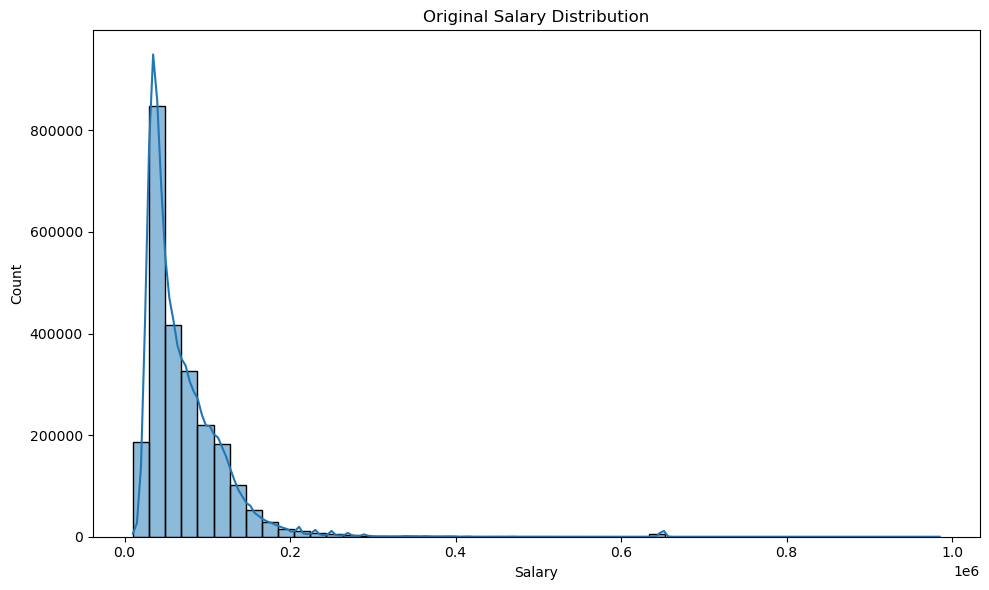

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(df['SALARY'], kde=True, bins=50)
plt.title("Original Salary Distribution")
plt.xlabel("Salary")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Apply log transformation to salary

In [35]:
df['log_SALARY'] = np.log(df['SALARY'])

Log-transformed salary distribution

/Users/zouzhaoling/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


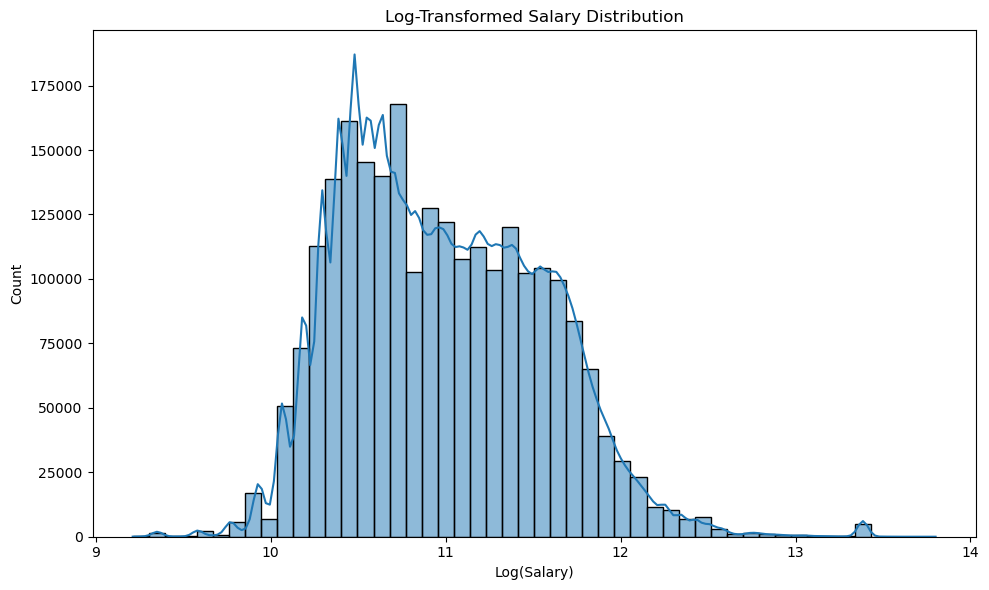

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(df['log_SALARY'], kde=True, bins=50)
plt.title("Log-Transformed Salary Distribution")
plt.xlabel("Log(Salary)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Check if log transformation made the distribution more normal

Text(0.5, 1.0, 'Q-Q Plot: Original Salary')

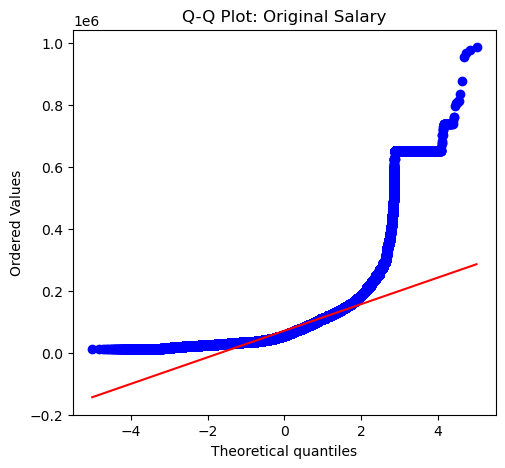

In [37]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
stats.probplot(df['SALARY'], dist="norm", plot=plt)
plt.title('Q-Q Plot: Original Salary')

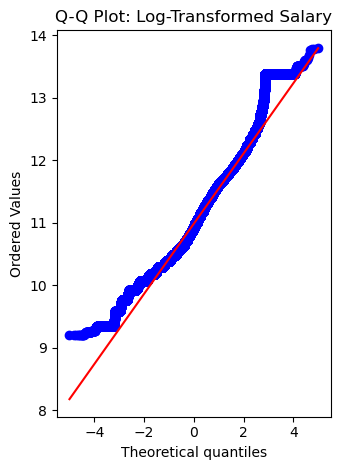

In [38]:
plt.subplot(1, 2, 2)
stats.probplot(df['log_SALARY'], dist="norm", plot=plt)
plt.title('Q-Q Plot: Log-Transformed Salary')
plt.tight_layout()
plt.show()

### 5.2 Salary by Location

Top 10 states by job postings

In [39]:
df_cleaned = Job_Postings_with_Salary[(Job_Postings_with_Salary['SALARY'] > 0) & 
                                      (Job_Postings_with_Salary['SALARY'] < 500000) & 
                                      (Job_Postings_with_Salary['STATE'].notna())]
top_states = df_cleaned['STATE'].value_counts().head(10).index

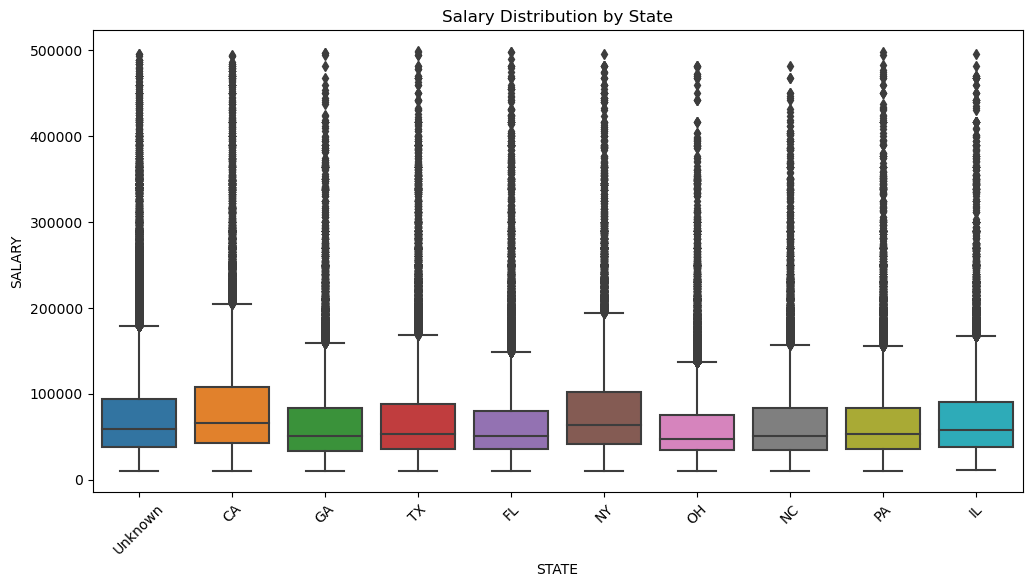

In [40]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned[df_cleaned['STATE'].isin(top_states)],
            x='STATE', y='SALARY')
plt.xticks(rotation=45)
plt.title("Salary Distribution by State")
plt.show()

### 5.3 Salary Trends Over Time

<Figure size 1200x600 with 0 Axes>

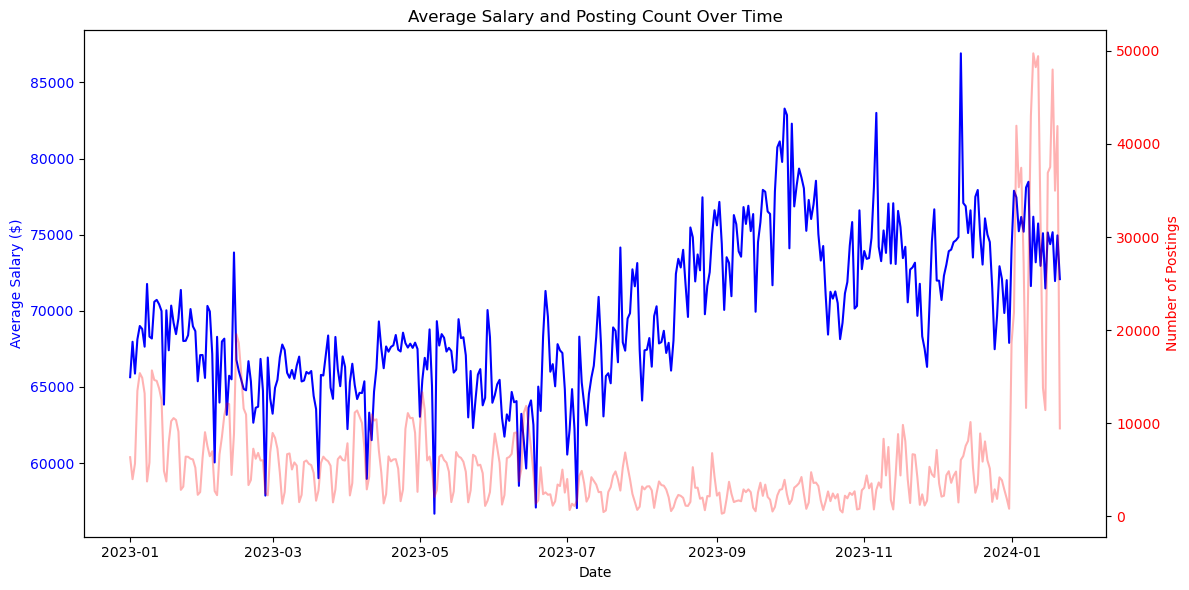

In [41]:
import seaborn as sns
import numpy as np

# Average salary trend over time

plt.figure(figsize=(12, 6))

# Calculate daily average salary
daily_salary = Job_Postings_with_Salary.groupby('POST_DATE')['SALARY'].agg(['mean', 'count']).reset_index()

 # Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average salary
ax1.plot(daily_salary['POST_DATE'], daily_salary['mean'], color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Salary ($)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot posting count on secondary axis
ax2 = ax1.twinx()
ax2.plot(daily_salary['POST_DATE'], daily_salary['count'], color='r', alpha=0.3)
ax2.set_ylabel('Number of Postings', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Average Salary and Posting Count Over Time')
plt.tight_layout()
plt.show()

### 5.4 Correlation Analysis

Correlation analysis

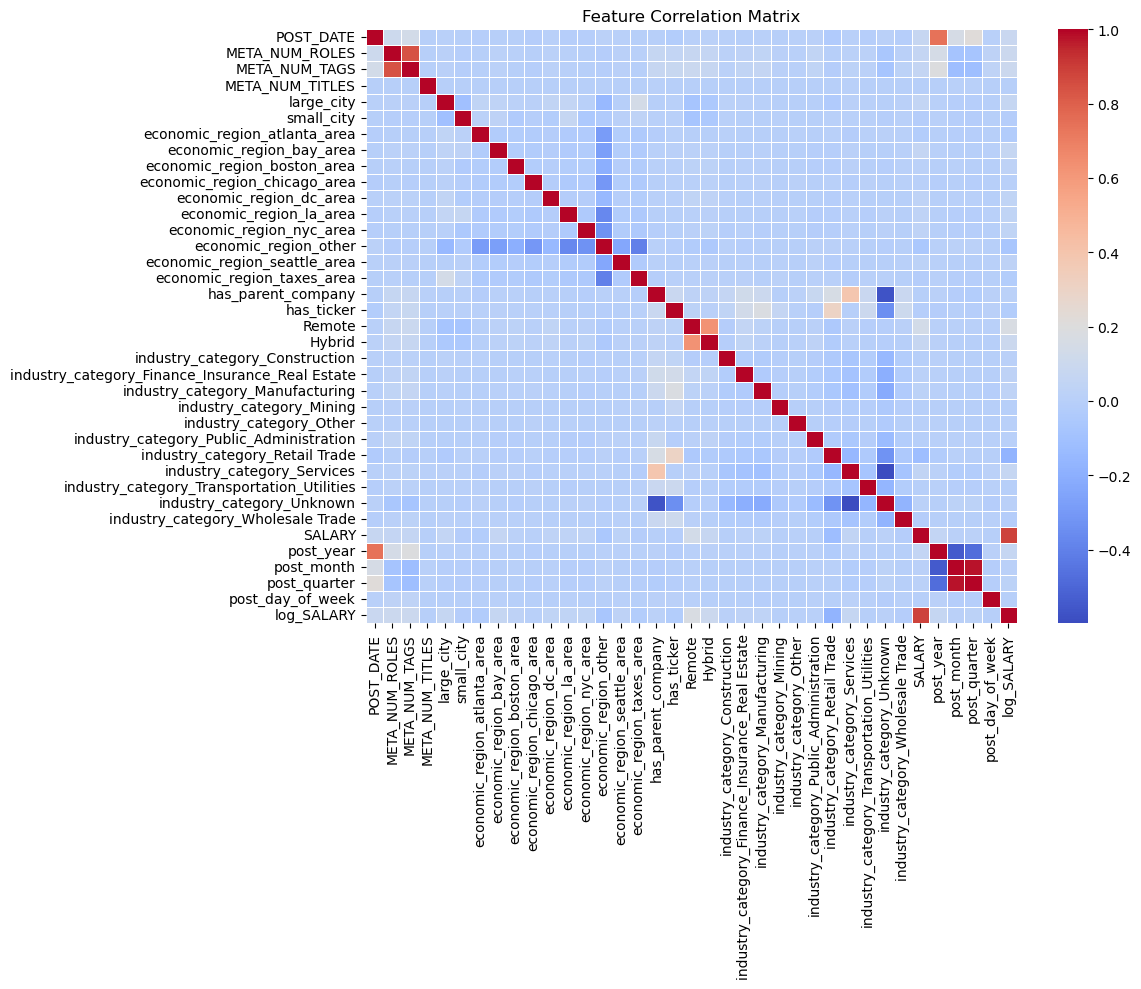

In [42]:
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

Top correlations with salary

In [43]:
top_corr = corr_matrix['SALARY'].sort_values(ascending=False)
print("\nTop correlations with SALARY:")
print(top_corr)


Top correlations with SALARY:
SALARY                                             1.000000
log_SALARY                                         0.884659
Remote                                             0.137843
Hybrid                                             0.074447
POST_DATE                                          0.072042
META_NUM_TAGS                                      0.063056
META_NUM_ROLES                                     0.062654
economic_region_bay_area                           0.060302
post_year                                          0.055767
large_city                                         0.055621
industry_category_Services                         0.045832
economic_region_nyc_area                           0.035787
economic_region_la_area                            0.034188
economic_region_dc_area                            0.034046
industry_category_Manufacturing                    0.024877
economic_region_seattle_area                       0.021472
industry_

### 5.5 Industry Analysis

Create a Sankey diagram for salary distribution by industry

In [44]:
naics_dict = {
    44: 'Retail Trade',
    722511: 'Full-Service Restaurants',
    722513: 'Limited-Service Restaurants',
    7225: 'Restaurants and Other Eating Places',
    5413: 'Architectural, Engineering, and Related Service',
    6213: 'Offices of Other Health Practitioners',
    6216: 'Home Health Care Services',
    4461: 'Health and Personal Care Stores',
    6241: 'Individual and Family Services',
    5617: 'Services to Buildings and Dwellings'
}

In [45]:
df_cleaned = Job_Postings_with_Salary[(Job_Postings_with_Salary['SALARY'] > 0) & 
                                     (Job_Postings_with_Salary['SALARY'] < 500000) & 
                                     (Job_Postings_with_Salary['NAICS_PRIMARY'].notna())]
df_cleaned = df_cleaned[df_cleaned['NAICS_PRIMARY'].str.lower() != 'unknown']
df_cleaned = df_cleaned[df_cleaned['NAICS_PRIMARY'].str.lower() != 'nan' ]
df_cleaned['NAICS_PRIMARY'] = pd.to_numeric(df_cleaned['NAICS_PRIMARY'].str.replace('.0', '', regex=True), errors='coerce')
df_cleaned['NAICS_FULL_NAME'] = df_cleaned['NAICS_PRIMARY'].map(naics_dict)

In [46]:
def classify_salary(salary):
    if salary > 100000:
        return 'High Salary(>100000)'
    elif salary >= 50000:
        return 'Medium Salary(50000-100000)'
    else:
        return 'Low Salary(<50000)'
df_cleaned['Salary_Class'] = df_cleaned['SALARY'].apply(classify_salary)

In [47]:
sic_salary_dist = df_cleaned.groupby(['NAICS_FULL_NAME', 'Salary_Class']).size().reset_index(name='Job_Count')
top_sic_list = df_cleaned['NAICS_FULL_NAME'].value_counts().head(10).index.tolist()
top_sic_df = sic_salary_dist[sic_salary_dist['NAICS_FULL_NAME'].isin(top_sic_list)]
sources = top_sic_df['NAICS_FULL_NAME'].tolist()
targets = top_sic_df['Salary_Class'].tolist()
values = top_sic_df['Job_Count'].tolist()

In [48]:
all_labels = list(set(sources + targets))
source_indices = [all_labels.index(s) for s in sources]
target_indices = [all_labels.index(t) for t in targets]

In [49]:
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_labels,
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values
    )
))

In [50]:
fig.update_layout(title_text="Top 10 Job Industries: Salary Distribution",
                  width=1200,
                  height=800)
fig.show()

## 6. Model Building and Evaluation

### 6.1 Data Preparation for Modeling

Drop original POST_DATE as it's not usable in linear regression

In [51]:
df = df.drop(['POST_DATE'], axis=1)

We'll use all features and log-transformed salary

In [52]:
X = df.drop(['SALARY', 'log_SALARY'], axis=1)  # Drop both salary columns
y_original = df['SALARY']  # Original salary for reference
y = df['log_SALARY']  # Log-transformed salary as target

Print selected features

In [53]:
print("\nSelected features for modeling:")
print(X.columns.tolist())


Selected features for modeling:
['META_NUM_ROLES', 'META_NUM_TAGS', 'META_NUM_TITLES', 'large_city', 'small_city', 'economic_region_atlanta_area', 'economic_region_bay_area', 'economic_region_boston_area', 'economic_region_chicago_area', 'economic_region_dc_area', 'economic_region_la_area', 'economic_region_nyc_area', 'economic_region_other', 'economic_region_seattle_area', 'economic_region_taxes_area', 'has_parent_company', 'has_ticker', 'Remote', 'Hybrid', 'industry_category_Construction', 'industry_category_Finance_Insurance_Real Estate', 'industry_category_Manufacturing', 'industry_category_Mining', 'industry_category_Other', 'industry_category_Public_Administration', 'industry_category_Retail Trade', 'industry_category_Services', 'industry_category_Transportation_Utilities', 'industry_category_Unknown', 'industry_category_Wholesale Trade', 'post_year', 'post_month', 'post_quarter', 'post_day_of_week']


### 6.2 Train-Test Split

Split the data into training and testing sets

In [54]:
X_train, X_test, y_train, y_test, y_orig_train, y_orig_test = train_test_split(
    X, y, y_original, test_size=0.2, random_state=42)
print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (1932328, 34)
Testing set size: (483083, 34)


### 6.3 Feature Scaling

Create a scaler for numerical features

In [55]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 6.4 Basic Linear Regression Model

In [56]:
print("\n--- Basic Linear Regression Model ---")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)


--- Basic Linear Regression Model ---


LinearRegression()

Predictions (log scale)

In [57]:
y_pred_lr_log = lr.predict(X_test_scaled)

Convert predictions back to original scale for interpretability

In [58]:
y_pred_lr = np.exp(y_pred_lr_log)

Evaluation metrics on original scale

In [59]:
lr_mse = mean_squared_error(y_orig_test, y_pred_lr)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_orig_test, y_pred_lr)
lr_r2 = r2_score(y_orig_test, y_pred_lr)

In [60]:
print(f"Mean Squared Error (MSE): {lr_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {lr_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {lr_mae:.2f}")
print(f"R² Score (on original scale): {lr_r2:.4f}")

Mean Squared Error (MSE): 2620890880.24
Root Mean Squared Error (RMSE): 51194.64
Mean Absolute Error (MAE): 30888.38
R² Score (on original scale): 0.0087


R² on log scale for comparison

In [61]:
lr_log_r2 = r2_score(y_test, y_pred_lr_log)
print(f"R² Score (on log scale): {lr_log_r2:.4f}")

R² Score (on log scale): 0.0915


Feature importance

In [62]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
print("\nTop 10 most influential features:")
print(coef_df.head(10))
print("\nBottom 10 least influential features:")
print(coef_df.tail(10))


Top 10 most influential features:
                         Feature   Coefficient
12         economic_region_other  4.842885e+06
14    economic_region_taxes_area  2.466371e+06
10       economic_region_la_area  2.279760e+06
11      economic_region_nyc_area  2.047278e+06
8   economic_region_chicago_area  1.916293e+06
5   economic_region_atlanta_area  1.795365e+06
6       economic_region_bay_area  1.723410e+06
13  economic_region_seattle_area  1.489961e+06
7    economic_region_boston_area  1.262867e+06
9        economic_region_dc_area  9.261232e+05

Bottom 10 least influential features:
                                            Feature   Coefficient
22                         industry_category_Mining -2.635641e+06
24          industry_category_Public_Administration -7.302480e+06
19                   industry_category_Construction -8.082187e+06
27       industry_category_Transportation_Utilities -9.081264e+06
29                industry_category_Wholesale Trade -9.663215e+06
20  industry_

Plot actual vs predicted values

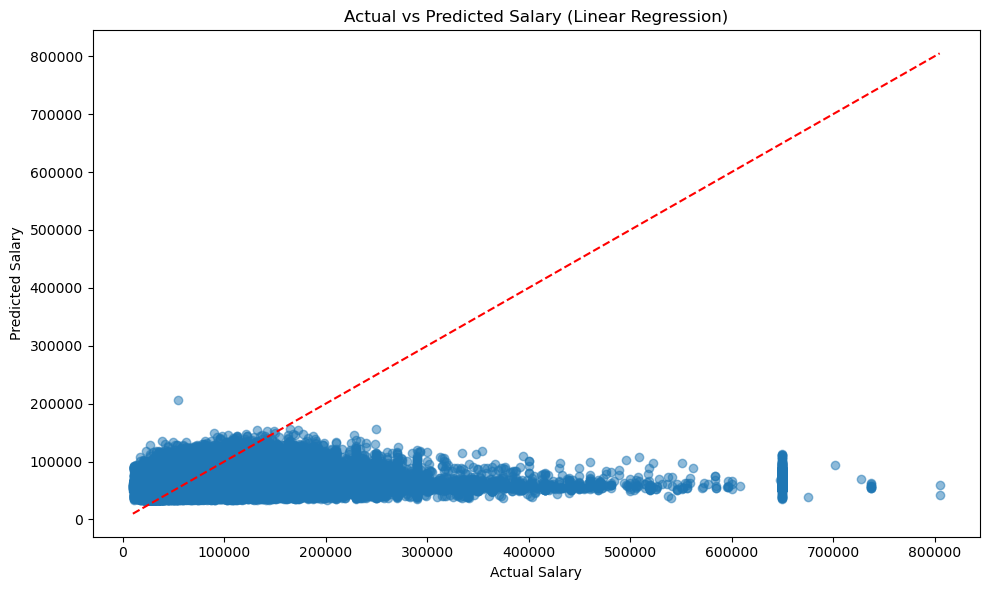

In [63]:
plt.figure(figsize=(10, 6))
plt.scatter(y_orig_test, y_pred_lr, alpha=0.5)
plt.plot([y_orig_test.min(), y_orig_test.max()], [y_orig_test.min(), y_orig_test.max()], 'r--')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary (Linear Regression)")
plt.tight_layout()
plt.show()

### 6.5 Ridge Regression Model (L2 regularization)

In [64]:
print("\n--- Ridge Regression Model ---")
# Setup Ridge with cross-validation to find the best alpha
ridge_alphas = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
ridge_cv = GridSearchCV(
    Ridge(), 
    param_grid={'alpha': ridge_alphas},
    cv=5, 
    scoring='neg_mean_squared_error'
)
ridge_cv.fit(X_train_scaled, y_train)


--- Ridge Regression Model ---


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
             scoring='neg_mean_squared_error')

Best alpha

In [65]:
print(f"Best Ridge alpha: {ridge_cv.best_params_['alpha']}")

Best Ridge alpha: 100.0


Evaluate on test set

In [66]:
ridge = Ridge(alpha=ridge_cv.best_params_['alpha'])
ridge.fit(X_train_scaled, y_train)
y_pred_ridge_log = ridge.predict(X_test_scaled)

Convert to original scale

In [67]:
y_pred_ridge = np.exp(y_pred_ridge_log)

Metrics

In [68]:
ridge_mse = mean_squared_error(y_orig_test, y_pred_ridge)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mae = mean_absolute_error(y_orig_test, y_pred_ridge)
ridge_r2 = r2_score(y_orig_test, y_pred_ridge)

In [69]:
print(f"Mean Squared Error (MSE): {ridge_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {ridge_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {ridge_mae:.2f}")
print(f"R² Score (on original scale): {ridge_r2:.4f}")
print(f"R² Score (on log scale): {r2_score(y_test, y_pred_ridge_log):.4f}")

Mean Squared Error (MSE): 2620890888.31
Root Mean Squared Error (RMSE): 51194.64
Mean Absolute Error (MAE): 30888.38
R² Score (on original scale): 0.0087
R² Score (on log scale): 0.0915


### 6.6 Lasso Regression Model (L1 regularization)

In [70]:
print("\n--- Lasso Regression Model ---")
# Setup Lasso with cross-validation to find the best alpha
lasso_alphas = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
lasso_cv = GridSearchCV(
    Lasso(max_iter=10000), 
    param_grid={'alpha': lasso_alphas},
    cv=5, 
    scoring='neg_mean_squared_error'
)
lasso_cv.fit(X_train_scaled, y_train)


--- Lasso Regression Model ---


GridSearchCV(cv=5, estimator=Lasso(max_iter=10000),
             param_grid={'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
             scoring='neg_mean_squared_error')

Best alpha

In [71]:
print(f"Best Lasso alpha: {lasso_cv.best_params_['alpha']}")

Best Lasso alpha: 0.01


Evaluate on test set

In [72]:
lasso = Lasso(alpha=lasso_cv.best_params_['alpha'], max_iter=10000)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso_log = lasso.predict(X_test_scaled)

Convert to original scale

In [73]:
y_pred_lasso = np.exp(y_pred_lasso_log)

Metrics

In [74]:
lasso_mse = mean_squared_error(y_orig_test, y_pred_lasso)
lasso_rmse = np.sqrt(lasso_mse)
lasso_mae = mean_absolute_error(y_orig_test, y_pred_lasso)
lasso_r2 = r2_score(y_orig_test, y_pred_lasso)

In [75]:
print(f"Mean Squared Error (MSE): {lasso_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {lasso_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {lasso_mae:.2f}")
print(f"R² Score (on original scale): {lasso_r2:.4f}")
print(f"R² Score (on log scale): {r2_score(y_test, y_pred_lasso_log):.4f}")

Mean Squared Error (MSE): 2640847702.20
Root Mean Squared Error (RMSE): 51389.18
Mean Absolute Error (MAE): 31073.42
R² Score (on original scale): 0.0012
R² Score (on log scale): 0.0849


Feature selection with Lasso

In [76]:
lasso_coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
})
lasso_coef_df = lasso_coef_df.sort_values(by='Coefficient', ascending=False)
print("\nTop 10 most influential features (Lasso):")
print(lasso_coef_df.head(10))
print("\nFeatures eliminated by Lasso (coefficient = 0):")
print(lasso_coef_df[lasso_coef_df['Coefficient'] == 0])


Top 10 most influential features (Lasso):
                       Feature  Coefficient
17                      Remote     0.081559
0               META_NUM_ROLES     0.030068
3                   large_city     0.029086
30                   post_year     0.026810
6     economic_region_bay_area     0.019514
32                post_quarter     0.018637
26  industry_category_Services     0.013839
1                META_NUM_TAGS     0.007888
11    economic_region_nyc_area     0.006330
10     economic_region_la_area     0.005555

Features eliminated by Lasso (coefficient = 0):
                                            Feature  Coefficient
24          industry_category_Public_Administration         -0.0
23                          industry_category_Other          0.0
2                                   META_NUM_TITLES         -0.0
27       industry_category_Transportation_Utilities         -0.0
28                        industry_category_Unknown         -0.0
31                                


## 7. Random Forest Classification Model

In [77]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

Define the salary range categories

In [79]:
bins = [0, 30000, 90000, 150000, np.inf]
labels = ["Low", "Medium", "High", "Very_High"]

In [80]:
df["salary_range"] = pd.cut(
    df["SALARY"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

In [81]:
print(df["salary_range"].value_counts())

salary_range
Medium       1546641
High          478945
Low           269864
Very_High     119961
Name: count, dtype: int64


### 7.1 Prepare Data and Train Random Forest Model

1. Define X and y for classification

   We'll drop 'SALARY' and 'salary_range' from features

In [82]:
y = df["salary_range"]
X = df.drop(columns=["SALARY", "salary_range", "POST_DATE", "META_NUM_TAGS", "log_SALARY"], errors="ignore")

2. Impute numeric columns

In [83]:
imputer = SimpleImputer(strategy="mean")
X_numeric = X.select_dtypes(include=[np.number])
X_numeric_imputed = pd.DataFrame(
    imputer.fit_transform(X_numeric),
    columns=X_numeric.columns
)

3. Encode categoricals

In [84]:
X_categorical = X.select_dtypes(exclude=[np.number])
if not X_categorical.empty:
    X_categorical_encoded = X_categorical.apply(
        lambda col: LabelEncoder().fit_transform(col.astype(str))
    )
    # Combine numeric + categorical
    X_final = pd.concat([X_numeric_imputed, X_categorical_encoded], axis=1)
else:
    X_final = X_numeric_imputed

4. Train/test split

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y  # stratify ensures each class is represented proportionally
)

5. Fit a Random Forest Classifier

In [86]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

6. Evaluate

In [87]:
y_pred = clf.predict(X_test)

In [88]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6105534659675459
Classification Report:
               precision    recall  f1-score   support

        High       0.32      0.13      0.19     95789
         Low       0.35      0.11      0.17     53973
      Medium       0.66      0.89      0.76    309329
   Very_High       0.16      0.05      0.07     23992

    accuracy                           0.61    483083
   macro avg       0.37      0.30      0.30    483083
weighted avg       0.53      0.61      0.54    483083

Confusion Matrix:
 [[ 12741   1987  78975   2086]
 [  1841   6196  45654    282]
 [ 21925   9102 274928   3374]
 [  3295    425  19189   1083]]


### 7.2 Feature Importance Analysis

Visualize feature importance

In [89]:
feature_importance = clf.feature_importances_
features = X.columns
sorted_idx = np.argsort(feature_importance)

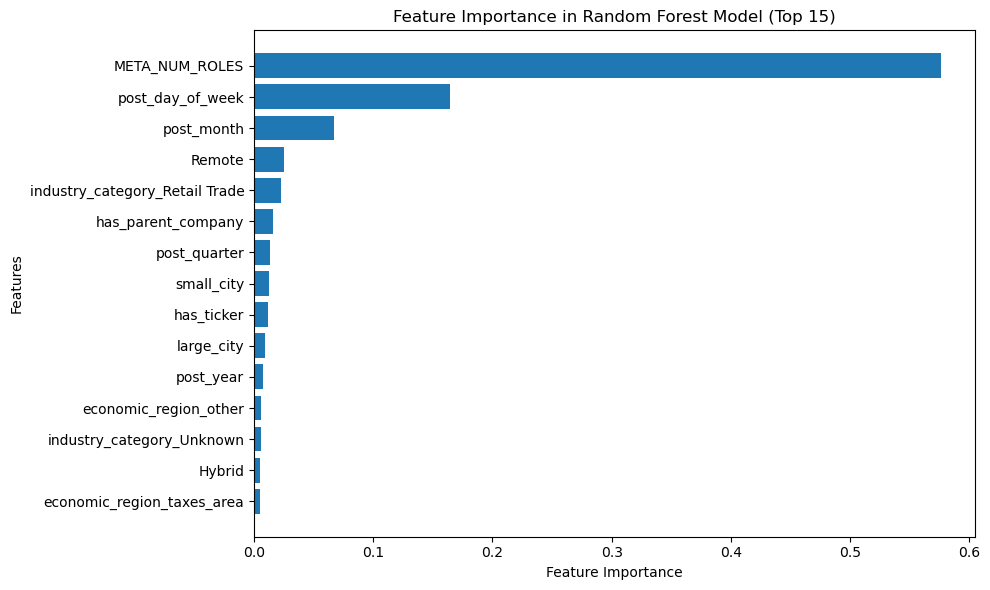

In [90]:
plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx][-15:], feature_importance[sorted_idx][-15:])  # Show only top 15 features
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model (Top 15)")
plt.tight_layout()
plt.show()

### 7.3 Random Forest Model Summary

Calculate precision, recall, and F1 score for each class

In [91]:
classification_results = classification_report(y_test, y_pred, output_dict=True)

Create summary table

In [92]:
summary_data = {
    'Class': list(classification_results.keys())[:-3],  # Exclude 'accuracy', 'macro avg', 'weighted avg'
    'Precision': [classification_results[k]['precision'] for k in list(classification_results.keys())[:-3]],
    'Recall': [classification_results[k]['recall'] for k in list(classification_results.keys())[:-3]],
    'F1-Score': [classification_results[k]['f1-score'] for k in list(classification_results.keys())[:-3]],
    'Support': [classification_results[k]['support'] for k in list(classification_results.keys())[:-3]]
}

In [93]:
summary_df = pd.DataFrame(summary_data)
print("Classification Performance Summary:")
print(summary_df)

Classification Performance Summary:
       Class  Precision    Recall  F1-Score  Support
0       High   0.320110  0.133011  0.187933    95789
1        Low   0.349859  0.114798  0.172872    53973
2     Medium   0.656551  0.888788  0.755219   309329
3  Very_High   0.158681  0.045140  0.070286    23992


Overall accuracy

In [94]:
print(f"\nOverall Accuracy: {classification_results['accuracy']:.4f}")


Overall Accuracy: 0.6106


Print top 10 most important features

In [95]:
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

In [96]:
print("\nTop 10 most important features:")
print(importance_df.head(10))


Top 10 most important features:
                           Feature  Importance
0                   META_NUM_ROLES    0.576161
32                post_day_of_week    0.164330
30                      post_month    0.067155
16                          Remote    0.025013
24  industry_category_Retail Trade    0.022686
14              has_parent_company    0.016209
31                    post_quarter    0.013093
3                       small_city    0.012679
15                      has_ticker    0.011524
2                       large_city    0.009460


## 8. XGBoost Model

XGBoost is an optimized gradient boosting library designed for efficiency, flexibility, and portability. Let's apply it to our dataset to see if we can improve prediction performance compared to our previous models.

### 8.1 XGBoost Regression Model

In [97]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

Prepare the same data we used for our previous models

Use log-transformed target for better performance

In [98]:
X = df.drop(['SALARY', 'log_SALARY', 'salary_range'], axis=1, errors='ignore')
y_original = df['SALARY']  # Original salary for reference
y = df['log_SALARY']  # Log-transformed salary as target

Split the data into training and testing sets

In [99]:
X_train, X_test, y_train, y_test, y_orig_train, y_orig_test = train_test_split(
    X, y, y_original, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (1932328, 34)
Testing set size: (483083, 34)


Scale features

In [100]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Define XGBoost model and hyperparameter grid for tuning

In [101]:
print("\n--- XGBoost Regression Model ---")
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', 
                               eval_metric='rmse', 
                               random_state=42)


--- XGBoost Regression Model ---


In [102]:
param_grid = {
    'n_estimators': [300, 500, 800],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.005, 0.01, 0.05],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_lambda': [1, 3, 5],
    'reg_alpha': [0, 1, 3],
}

Perform hyperparameter tuning with cross-validation

Use RandomizedSearchCV for efficient hyperparameter tuning

In [103]:
random_search = RandomizedSearchCV(
    xgb_regressor,
    param_distributions=param_grid,
    n_iter=15,  # Try 15 parameter combinations (for faster execution)
    cv=5,       # 5-fold cross-validation
    scoring='r2',
    verbose=1,
    n_jobs=-1,  # Use all available cores
    random_state=42
)

In [104]:
print("Training XGBoost model with hyperparameter tuning...")
random_search.fit(X_train_scaled, y_train)

Training XGBoost model with hyperparameter tuning...
Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='rmse',
                                          feature_types=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rat...
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.005, 0.01, 0.05],
                                        'max_depth': [4, 6, 8],
                                        'n_estimators': [300, 500, 800],
                                        'reg_alpha': [0, 1, 3],
                                        'reg_lambda': [1, 3, 5],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42, scoring='r2', verbose=1)

Evaluate the best model found

Get the best model

In [105]:
best_xgb = random_search.best_estimator_
print(f"Best parameters found: {random_search.best_params_}")

Best parameters found: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 3, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


Make predictions on test set (log scale)

In [106]:
y_pred_xgb_log = best_xgb.predict(X_test_scaled)

Convert predictions back to original scale

In [107]:
y_pred_xgb = np.exp(y_pred_xgb_log)

Calculate metrics

In [108]:
xgb_mse = mean_squared_error(y_orig_test, y_pred_xgb)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_orig_test, y_pred_xgb)
xgb_r2 = r2_score(y_orig_test, y_pred_xgb)
xgb_log_r2 = r2_score(y_test, y_pred_xgb_log)

In [109]:
print(f"Mean Squared Error (MSE): {xgb_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {xgb_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {xgb_mae:.2f}")
print(f"R² Score (on original scale): {xgb_r2:.4f}")
print(f"R² Score (on log scale): {xgb_log_r2:.4f}")

Mean Squared Error (MSE): 2551326421.05
Root Mean Squared Error (RMSE): 50510.66
Mean Absolute Error (MAE): 30041.04
R² Score (on original scale): 0.0350
R² Score (on log scale): 0.1340


Analyze feature importance

Get feature importance from the model

In [110]:
feature_importance = best_xgb.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

Display the top 15 most important features

In [111]:
print("\nTop 15 most important features:")
print(importance_df.head(15))


Top 15 most important features:
                           Feature  Importance
25  industry_category_Retail Trade    0.286837
17                          Remote    0.206422
5     economic_region_atlanta_area    0.051032
6         economic_region_bay_area    0.048160
3                       large_city    0.046246
14      economic_region_taxes_area    0.038404
12           economic_region_other    0.035769
18                          Hybrid    0.028830
30                       post_year    0.027885
1                    META_NUM_TAGS    0.025137
26      industry_category_Services    0.019592
11        economic_region_nyc_area    0.018636
9          economic_region_dc_area    0.018407
16                      has_ticker    0.013619
31                      post_month    0.013156


Plot feature importance

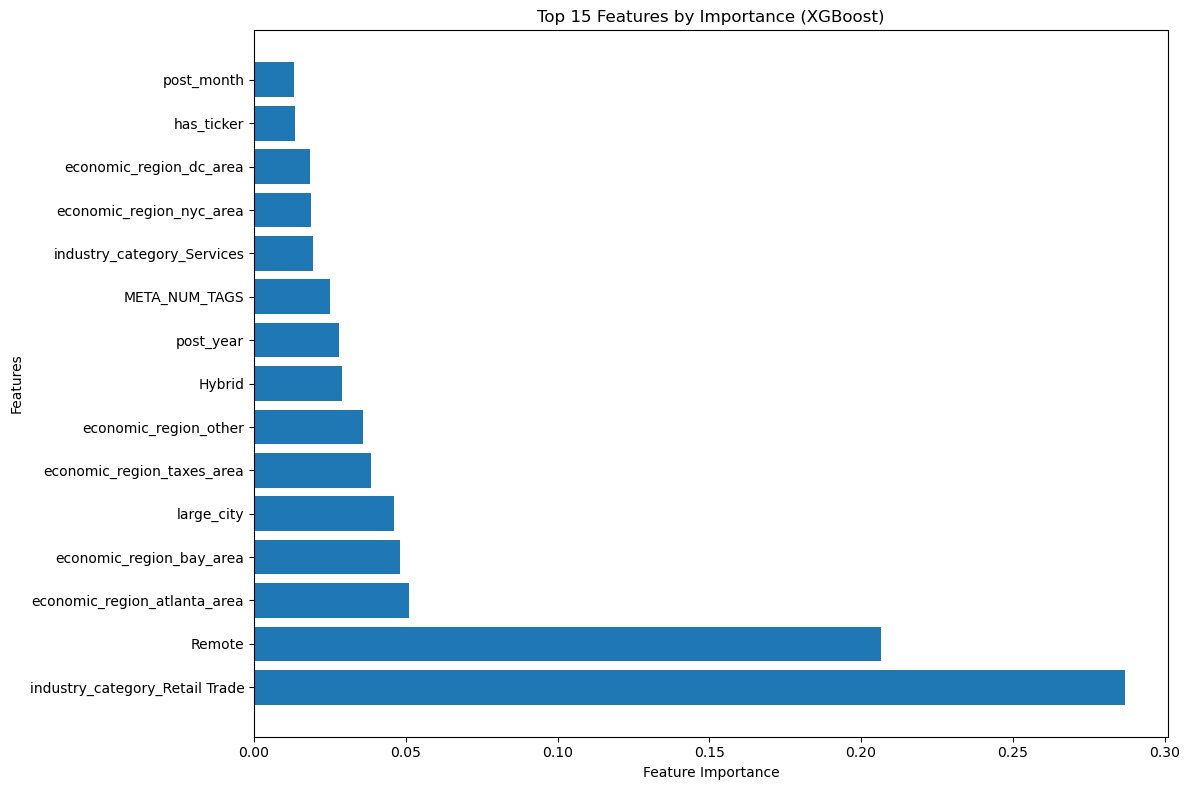

In [112]:
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'].head(15), importance_df['Importance'].head(15))
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 15 Features by Importance (XGBoost)")
plt.tight_layout()
plt.show()

Visualize actual vs predicted values

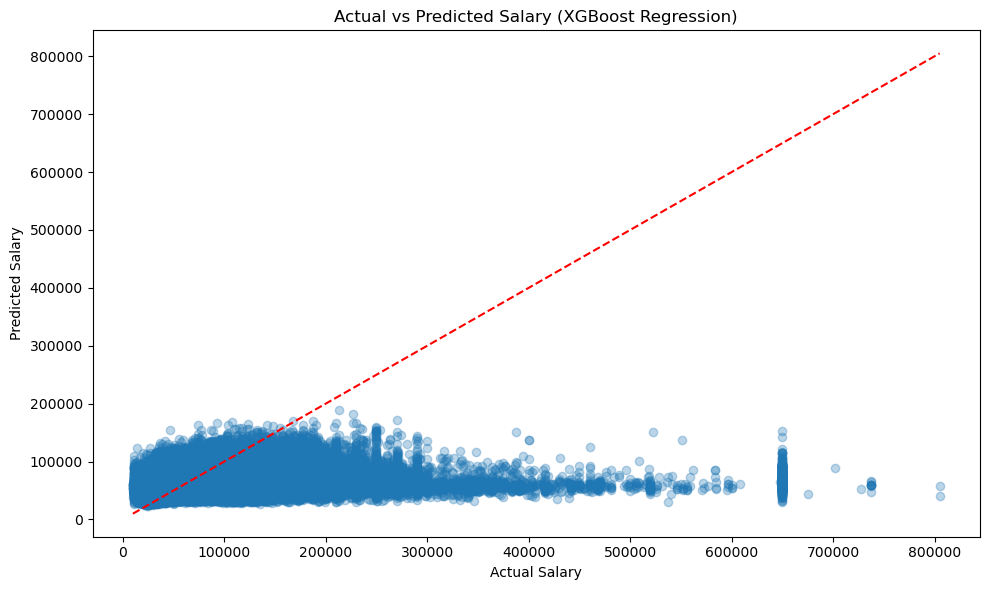

In [113]:
plt.figure(figsize=(10, 6))
plt.scatter(y_orig_test, y_pred_xgb, alpha=0.3)
plt.plot([y_orig_test.min(), y_orig_test.max()], 
         [y_orig_test.min(), y_orig_test.max()], 'r--')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary (XGBoost Regression)")
plt.tight_layout()
plt.show()

### 8.2 XGBoost Classification Model

Similar to our Random Forest approach, let's also try XGBoost for classification by categorizing salary ranges

Define salary range categories

In [114]:
bins = [0, 30000, 90000, 150000, np.inf]
labels = ["Low", "Medium", "High", "Very_High"]

Create a new column with salary categories

In [115]:
bins = [0, 30000, 90000, 150000, np.inf]
labels = [0, 1, 2, 3]  # Change to numeric labels instead of strings

# Create a new column with salary categories
df["salary_range"] = pd.cut(
    df["SALARY"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

In [116]:
print("Salary range distribution:")
print(df["salary_range"].value_counts())

Salary range distribution:
salary_range
1    1546641
2     478945
0     269864
3     119961
Name: count, dtype: int64


Prepare data for XGBoost classification

Define features and target for classification

In [117]:
y_class = df["salary_range"]
X_class = df.drop(columns=["SALARY", "salary_range", "POST_DATE", "log_SALARY"], errors="ignore")

Train-test split with stratification to maintain class distribution

In [118]:
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

Train XGBoost classifier

Initialize the XGBoost classifier

In [119]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)

Train the classifier

In [120]:
xgb_clf.fit(X_train_class, y_train_class)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

Make predictions

In [127]:
y_pred_class = xgb_clf.predict(X_test_class)

Evaluate the classification model

Calculate and display metrics

In [121]:
accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_class, y_pred_class))

Accuracy: 0.8469

Confusion Matrix:
[[ 19873  32741    953     78]
 [  3129 294612  12789    355]
 [  1923  20311  71258   1012]
 [   194    779    832  22187]]


Visualize the confusion matrix

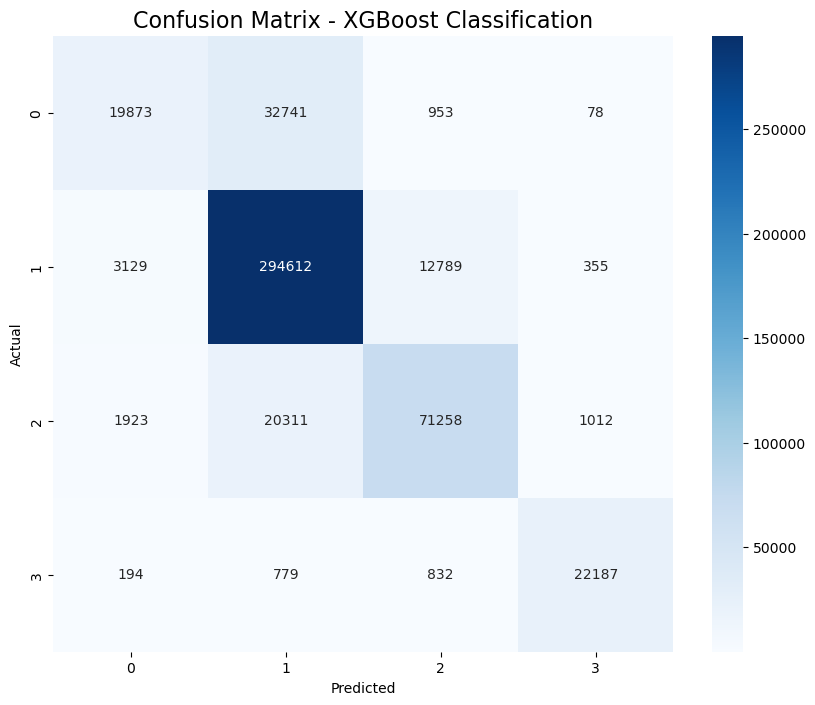

In [122]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_class, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost Classification')
plt.tight_layout()
plt.show()

### 8.3 Feature Importance Analysis for Classification

Get feature importance for classification

In [131]:
feature_imp_class = xgb_clf.feature_importances_
imp_df_class = pd.DataFrame({
    'Feature': X_class.columns,
    'Importance': feature_imp_class
}).sort_values('Importance', ascending=False)

Display top features

In [132]:
print("\nTop 15 most important features for classification:")
print(imp_df_class.head(15))


Top 15 most important features for classification:
                           Feature  Importance
25  industry_category_Retail Trade    0.211515
17                          Remote    0.151815
10         economic_region_la_area    0.065624
6         economic_region_bay_area    0.056719
13    economic_region_seattle_area    0.042320
5     economic_region_atlanta_area    0.037618
14      economic_region_taxes_area    0.034788
11        economic_region_nyc_area    0.033983
3                       large_city    0.032898
12           economic_region_other    0.031229
1                    META_NUM_TAGS    0.025669
28       industry_category_Unknown    0.025493
26      industry_category_Services    0.019359
18                          Hybrid    0.018076
7      economic_region_boston_area    0.017825


Plot feature importance

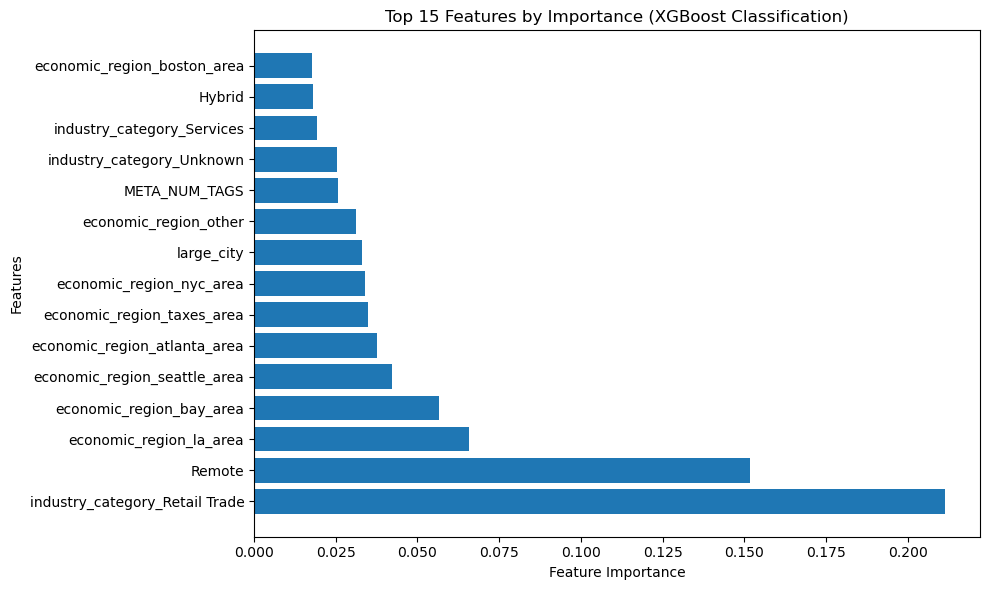

In [134]:
plt.figure(figsize=(10,6))
plt.barh(imp_df_class['Feature'].head(15), imp_df_class['Importance'].head(15))
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 15 Features by Importance (XGBoost Classification)")
plt.tight_layout()
plt.show()

## 9 Model Comparison

### 9.1 Regression Models Performance Comparison

| Model | MSE | RMSE | MAE | R²_Original | R²_Log |
|-------|-----|------|-----|-------------|--------|
| Linear Regression | 2,620,890,880.24 | 51,194.64 | 30,888.38 | 0.0087 | 0.0915 |
| Ridge Regression | 2,620,890,888.31 | 51,194.64 | 30,888.38 | 0.0087 | 0.0915 |
| Lasso Regression | 2,640,847,702.20 | 51,389.18 | 31,073.42 | 0.0012 | 0.0849 |
| XGBoost Regression | 2,551,326,421.05 | 50,510.66 | 30,041.04 | 0.0350 | 0.1340 |

All regression models performed poorly in predicting exact salary values. R² scores ranged from only 0.0012 to 0.0350, indicating minimal explanatory power. While XGBoost Regression achieved slightly better results with the lowest error metrics (RMSE: 50,510.66), the consistently poor performance across all models suggests that predicting precise salary figures is inherently challenging with the available features.

### 9.2 Classification Models Performance Comparison

#### Classification Models Performance Comparison
| Model | Accuracy |
|-------|----------|
| Random Forest | 0.6106 |
| XGBoost Classifier | 0.8469 |

#### XGBoost Classification Performance by Class

| Class | Precision | Recall | F1-Score |
|-------|-----------|--------|----------|
| Low (0) | 0.7900 | 0.3700 | 0.5000 |
| Medium (1) | 0.8500 | 0.9500 | 0.9000 |
| High (2) | 0.8300 | 0.7500 | 0.7900 |
| Very High (3) | 0.9400 | 0.9300 | 0.9300 |

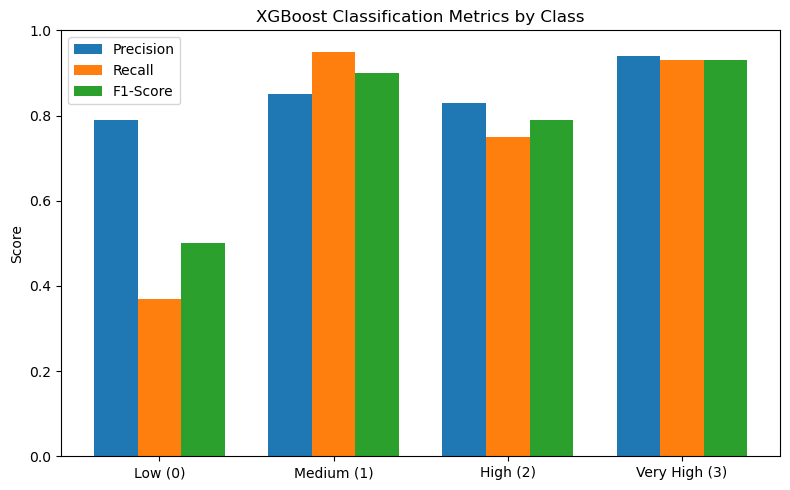

In [135]:
# Visualize classification performance by class
classes = ['Low (0)', 'Medium (1)', 'High (2)', 'Very High (3)']
precision = [0.79, 0.85, 0.83, 0.94]
recall = [0.37, 0.95, 0.75, 0.93]
f1 = [0.50, 0.90, 0.79, 0.93]

plt.figure(figsize=(8, 5))
x = np.arange(len(classes))
width = 0.25

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-Score')

plt.ylabel('Score')
plt.title('XGBoost Classification Metrics by Class')
plt.xticks(x, classes)
plt.legend()
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

#### Top 5 Features by Model

| Model | Top Feature 1 | Top Feature 2 | Top Feature 3 | Top Feature 4 | Top Feature 5 |
|-------|--------------|--------------|--------------|--------------|--------------|
| Random Forest | META_NUM_ROLES | post_day_of_week | post_month | Remote | industry_category_Retail Trade |
| XGBoost Classification | industry_category_Retail Trade | Remote | economic_region_la_area | economic_region_bay_area | economic_region_seattle_area |

The Random Forest and XGBoost classification models were developed to predict salary ranges (Low, Medium, High, Very High) rather than exact salary values. XGBoost significantly outperformed Random Forest with an accuracy of 84.69% compared to 61.06%. This substantial performance gap highlights XGBoost's ability to better capture the complex relationships between job posting features and salary categories.

Examining the XGBoost classifier's performance by class reveals excellent prediction capability for Medium (95% recall) and Very High (93% recall) salary ranges, while the Low salary range proved more challenging (37% recall). Feature importance analysis from both models consistently identified industry category (particularly Retail Trade), remote work status, and geographic location (especially coastal economic hubs) as the strongest predictors of salary ranges. The classification approach proved more effective than regression models, suggesting that predicting salary ranges is more practical than predicting exact values given the available features.

The classification models provide actionable insights for job seekers and employers, offering reliable salary range predictions based on job characteristics. XGBoost's superior performance makes it the recommended model for production use, potentially as part of a two-step system where salary range is first classified, followed by more precise within-range estimation.

### 9.3 Model Analysis
The Random Forest and XGBoost classification models were developed to predict salary ranges (Low, Medium, High, Very High) rather than exact salary values. XGBoost significantly outperformed Random Forest with an accuracy of 84.69% compared to 61.06%. This substantial performance gap highlights XGBoost's ability to better capture the complex relationships between job posting features and salary categories.
Examining the XGBoost classifier's performance by class reveals excellent prediction capability for Medium (95% recall) and Very High (93% recall) salary ranges, while the Low salary range proved more challenging (37% recall). Feature importance analysis from both models consistently identified industry category (particularly Retail Trade), remote work status, and geographic location (especially coastal economic hubs) as the strongest predictors of salary ranges.

## 10 Conclusions
The regression models in this study performed poorly across the board, with all models showing very low R² scores (between 0.0012 and 0.0350 on the original scale). Even the best-performing XGBoost regression model explained only 13.4% of the variance in log-transformed salary data. These consistently poor results indicate that predicting exact salary values is inherently challenging using the available features from job postings, likely due to the complex and multi-faceted nature of compensation determination.

The classification approach proved significantly more effective than regression models, suggesting that predicting salary ranges is more practical than predicting exact values given the available features. The classification models provide actionable insights for job seekers and employers, offering reliable salary range predictions based on job characteristics.

XGBoost's superior performance makes it the recommended model for production use, potentially as part of a two-step system where salary range is first classified, followed by more precise within-range estimation.